# Image Classification using **Quantum machine learning using idea of Convolutional Neural Net**.


# Can be called ⏩ **Quanvolutional Neural Network**

## Where Quantum layers extract features from images and then classical machine learning models are implemented over it.

# MNIST classification

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 58.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

**Make a folder named 'quanvolution' in your notebook before running below cells.**

In [20]:
n_epochs = 40   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 200    # Size of the train dataset
n_test = 80     # Size of the test dataset

SAVE_PATH = "quanvolution" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [12]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

## **We followed the scheme described in the Readme file of this repo to make the model.**


In [7]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev, interface="autograd")
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

**Below function defines the convolution scheme :**



1.   Image is divided into squares of 2x2 pixels.
2.   Each square is processed by the quantum circuit.
3.   the 4 expectation values are mapped into 4 different channels of a single  output pixel.



In [9]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

# **Quantum pre-processing of the dataset ▶**

### Since we are not going to train the quantum convolution layer, it is more efficient to apply it as a “pre-processing” layer to all the images of our dataset.
### Later an entirely classical model will be directly trained and tested on the pre-processed dataset, avoiding unnecessary repetitions of quantum computations.

### The pre-processed images will be saved in the folder **SAVE_PATH**.

###**Once saved**, they can be directly loaded by setting **PREPROCESS = False**, otherwise the quantum convolution is evaluated at each run of the code.

In [13]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


Let us visualize the effect of the quantum convolution layer on a batch of samples:



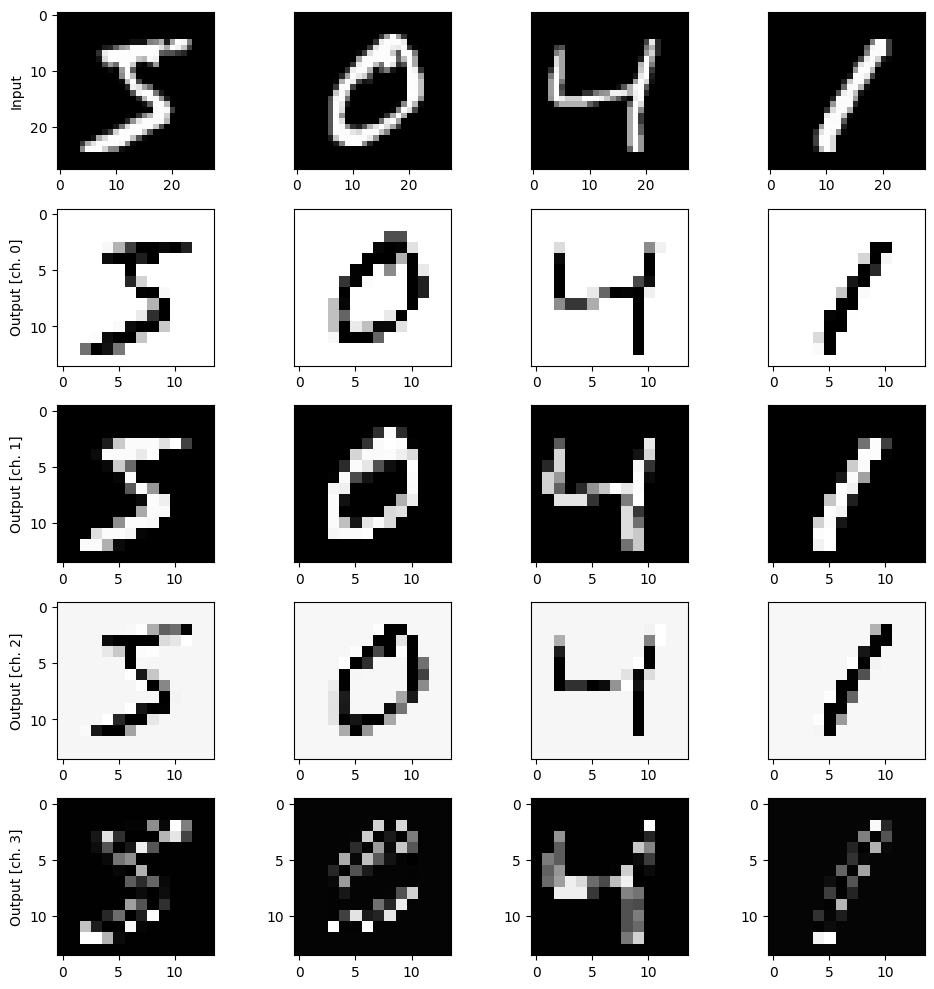

In [15]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()


Below each input image, the  
4 output channels generated by the quantum convolution are visualized in gray scale.

Downsampling of the resolution and some local distortion introduced by the quantum kernel.

On the other hand the global shape of the image is preserved, as expected for a convolution layer.



# **Hybrid quantum-classical model**


**After the application of the quantum convolution layer** we feed the resulting features into a classical neural network.

In [16]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# **Training of hybrid quantum model (With Quantum Layer)**

In [21]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/40
50/50 - 1s - loss: 2.3206 - accuracy: 0.2100 - val_loss: 2.0664 - val_accuracy: 0.2750 - 667ms/epoch - 13ms/step
Epoch 2/40
50/50 - 0s - loss: 1.3018 - accuracy: 0.6550 - val_loss: 1.6145 - val_accuracy: 0.5375 - 164ms/epoch - 3ms/step
Epoch 3/40
50/50 - 0s - loss: 0.8918 - accuracy: 0.7950 - val_loss: 1.2505 - val_accuracy: 0.6125 - 133ms/epoch - 3ms/step
Epoch 4/40
50/50 - 0s - loss: 0.6548 - accuracy: 0.8650 - val_loss: 1.1425 - val_accuracy: 0.6875 - 150ms/epoch - 3ms/step
Epoch 5/40
50/50 - 0s - loss: 0.5267 - accuracy: 0.8750 - val_loss: 1.0696 - val_accuracy: 0.6750 - 108ms/epoch - 2ms/step
Epoch 6/40
50/50 - 0s - loss: 0.4230 - accuracy: 0.9350 - val_loss: 1.0108 - val_accuracy: 0.7250 - 109ms/epoch - 2ms/step
Epoch 7/40
50/50 - 0s - loss: 0.3498 - accuracy: 0.9450 - val_loss: 0.9268 - val_accuracy: 0.7125 - 150ms/epoch - 3ms/step
Epoch 8/40
50/50 - 0s - loss: 0.3015 - accuracy: 0.9350 - val_loss: 0.9381 - val_accuracy: 0.7250 - 167ms/epoch - 3ms/step
Epoch 9/40
50/5

# **Training of classical model (Without Quantum Layer)**

In [22]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/40
50/50 - 1s - loss: 1.9516 - accuracy: 0.3650 - val_loss: 1.6805 - val_accuracy: 0.5625 - 698ms/epoch - 14ms/step
Epoch 2/40
50/50 - 0s - loss: 1.2390 - accuracy: 0.7850 - val_loss: 1.3613 - val_accuracy: 0.6500 - 112ms/epoch - 2ms/step
Epoch 3/40
50/50 - 0s - loss: 0.8862 - accuracy: 0.8750 - val_loss: 1.2036 - val_accuracy: 0.6500 - 160ms/epoch - 3ms/step
Epoch 4/40
50/50 - 0s - loss: 0.6802 - accuracy: 0.9300 - val_loss: 1.0892 - val_accuracy: 0.6750 - 147ms/epoch - 3ms/step
Epoch 5/40
50/50 - 0s - loss: 0.5566 - accuracy: 0.9350 - val_loss: 1.0173 - val_accuracy: 0.7000 - 147ms/epoch - 3ms/step
Epoch 6/40
50/50 - 0s - loss: 0.4576 - accuracy: 0.9450 - val_loss: 0.9770 - val_accuracy: 0.7125 - 114ms/epoch - 2ms/step
Epoch 7/40
50/50 - 0s - loss: 0.3940 - accuracy: 0.9500 - val_loss: 0.9361 - val_accuracy: 0.7250 - 154ms/epoch - 3ms/step
Epoch 8/40
50/50 - 0s - loss: 0.3420 - accuracy: 0.9600 - val_loss: 0.9073 - val_accuracy: 0.7375 - 161ms/epoch - 3ms/step
Epoch 9/40
50/5

Results
We can finally plot the test accuracy and the test loss with respect to the number of training epochs.

<ipython-input-23-c3ef9ba498fb>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


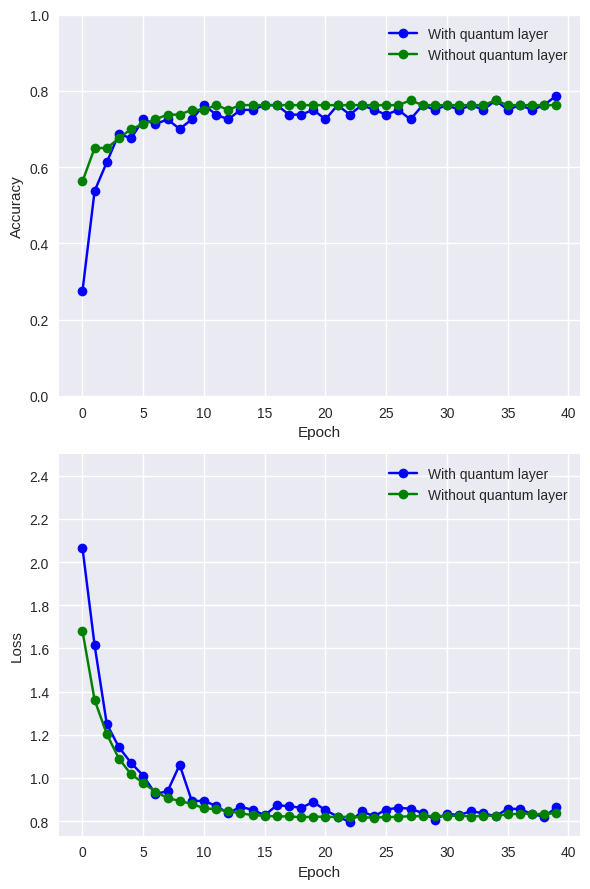

In [23]:
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()
